<a href="https://colab.research.google.com/github/Aarthy-26/UAV-Fruit-detection-and-counting-simulator/blob/main/cop_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


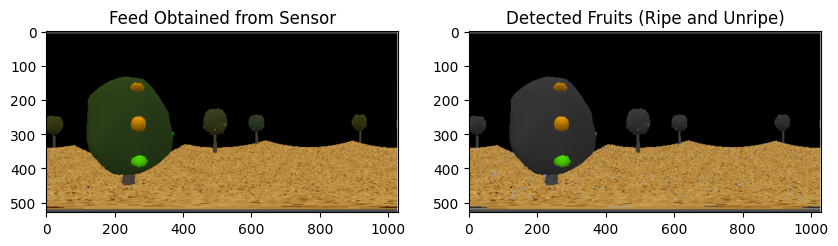

Screenshot 2024-11-12 054915.png: Ripe fruits = 2, Unripe fruits = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


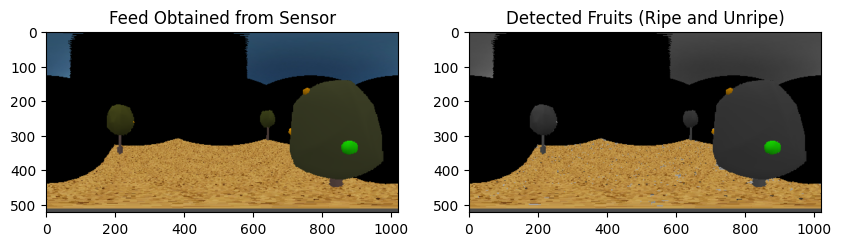

Screenshot 2024-11-12 054822.png: Ripe fruits = 0, Unripe fruits = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


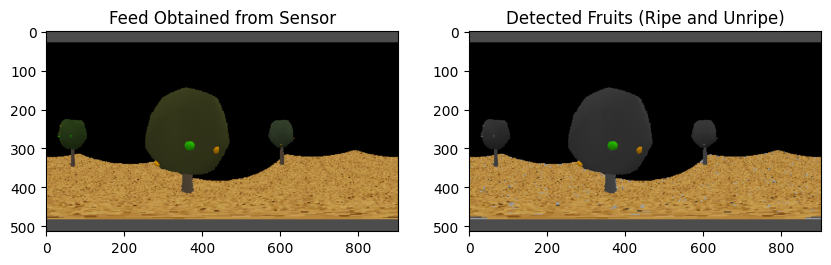

IM_1.png: Ripe fruits = 0, Unripe fruits = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


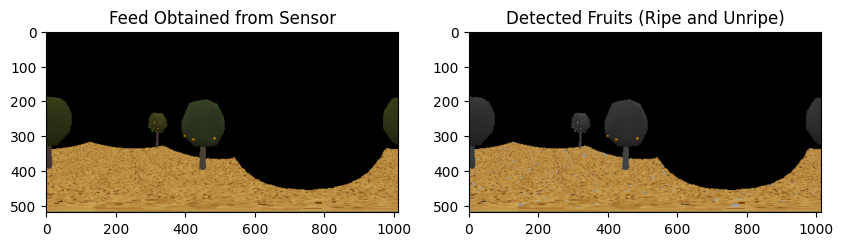

Screenshot 2024-11-12 054724.png: Ripe fruits = 0, Unripe fruits = 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


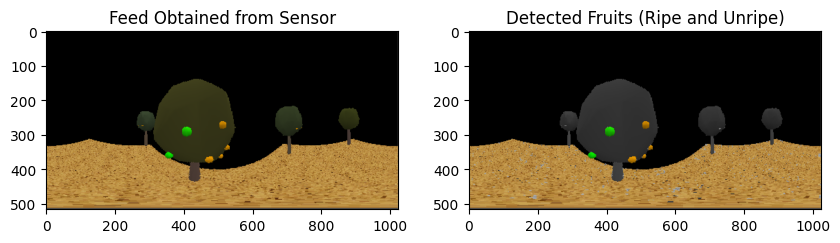

Screenshot 2024-11-12 054636.png: Ripe fruits = 4, Unripe fruits = 1

Image with the highest ripe fruits: Screenshot 2024-11-12 054636.png (4 ripe fruits)
Image with the lowest ripe fruits: Screenshot 2024-11-12 054822.png (0 ripe fruits)


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

# Load the image with error handling
def load_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Preprocess the image for CNN (VGG16 in this case)
def preprocess_image_for_cnn(image, target_size=(224, 224)):
    resized_image = cv2.resize(image, target_size)
    preprocessed_image = preprocess_input(np.expand_dims(resized_image, axis=0))
    return preprocessed_image

# Extract features using a pre-trained CNN (VGG16)
def extract_features(image):
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
    features = model.predict(image)
    return features

# Mask the image for yellow, orange, and green colors and count the fruits
# Mask the image for yellow, orange, and green colors and count the fruits
def mask_fruits(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define color ranges for yellow, orange, and green (in HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([20, 255, 255])

    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])

    # Create masks
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)

    # Apply morphological operations to reduce noise
    kernel = np.ones((5, 5), np.uint8)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, kernel)
    mask_orange = cv2.morphologyEx(mask_orange, cv2.MORPH_OPEN, kernel)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)

    # Combine the masks for ripe (yellow/orange) and unripe (green)
    combined_mask = cv2.bitwise_or(mask_yellow, mask_orange)
    combined_mask = cv2.bitwise_or(combined_mask, mask_green)

    # Count contours for each color
    ripe_count = count_fruits(mask_yellow) + count_fruits(mask_orange)  # Count for yellow and orange
    unripe_count = count_fruits(mask_green)  # Count for green

    # Extract the yellow/orange/green parts from the original image
    result = cv2.bitwise_and(image, image, mask=combined_mask)

    return combined_mask, result, ripe_count, unripe_count

# Count fruits in the mask using contours with refined filtering
def count_fruits(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Adjusted contour area threshold to remove noise
    min_contour_area = 300  # Adjust based on image resolution and fruit size

    # Further filter contours based on size and shape (aspect ratio)
    large_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_contour_area:
            # Calculate the bounding box and aspect ratio
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h
            # Add only contours with reasonable aspect ratio for roundish fruits
            if 0.75 < aspect_ratio < 1.5:
                large_contours.append(cnt)

    return len(large_contours)


# Convert the non-fruit parts to grayscale
def convert_to_grayscale(image, mask):
    # Convert the entire image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Convert grayscale back to RGB to match the original image's 3 channels
    grayscale_rgb_image = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB)

    # Apply the inverted mask to keep only the grayscale background
    grayscale_background = cv2.bitwise_and(grayscale_rgb_image, grayscale_rgb_image, mask=cv2.bitwise_not(mask))

    return grayscale_background

# Main function to process the image
def process_image(image_path):
    try:
        image = load_image(image_path)
    except ValueError as e:
        print(e)
        return None, None, None  # Return None in case of error

    # Step 1: Preprocess for CNN
    preprocessed_image = preprocess_image_for_cnn(image)

    # Step 2: Feature extraction (optional)
    features = extract_features(preprocessed_image)

    # Step 3: Mask the yellow, orange, and green parts and count the fruits
    mask, fruit_image, ripe_count, unripe_count = mask_fruits(image)

    # Step 4: Convert the non-fruit parts to grayscale
    grayscale_background = convert_to_grayscale(image, mask)

    # Step 5: Combine the grayscale background with the colored fruits
    final_image = cv2.add(grayscale_background, fruit_image)

    # Show the original and processed image
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.title('Feed Obtained from Sensor')
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title('Detected Fruits (Ripe and Unripe)')
    plt.imshow(final_image)

    plt.show()

    # Return the ripe and unripe counts
    return ripe_count, unripe_count

def process_folder(folder_path):
    """Processes images in a given folder and finds the image with the highest and lowest ripe fruits."""

    # Dictionary to store ripe and unripe fruit counts with image names
    fruit_counts = {}

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            ripe_count, unripe_count = process_image(image_path)

            # Skip if the image could not be processed
            if ripe_count is not None and unripe_count is not None:
                fruit_counts[filename] = (ripe_count, unripe_count)

                # Display ripe and unripe counts for each image
                print(f"{filename}: Ripe fruits = {ripe_count}, Unripe fruits = {unripe_count}")

    # Check if there are any images processed
    if fruit_counts:
        # Find the image with the highest and lowest ripe fruits
        image_with_max_ripe = max(fruit_counts, key=lambda x: fruit_counts[x][0])
        image_with_min_ripe = min(fruit_counts, key=lambda x: fruit_counts[x][0])

        # Display the results
        print(f"\nImage with the highest ripe fruits: {image_with_max_ripe} ({fruit_counts[image_with_max_ripe][0]} ripe fruits)")
        print(f"Image with the lowest ripe fruits: {image_with_min_ripe} ({fruit_counts[image_with_min_ripe][0]} ripe fruits)")
    else:
        print("No images were successfully processed.")

# Example usage
# Replace 'folder_path' with the path to your folder
folder_path = '/content/new_cop'
process_folder(folder_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


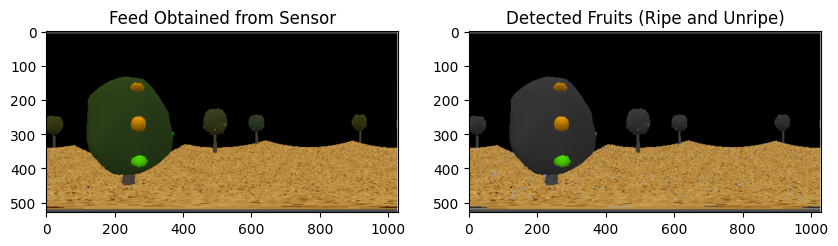

Screenshot 2024-11-12 054915.png: Ripe fruits = 2, Unripe fruits = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


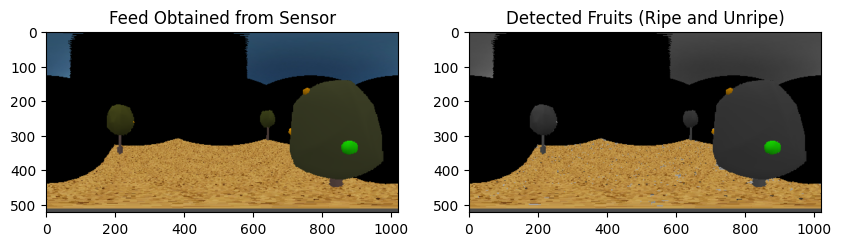

Screenshot 2024-11-12 054822.png: Ripe fruits = 0, Unripe fruits = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


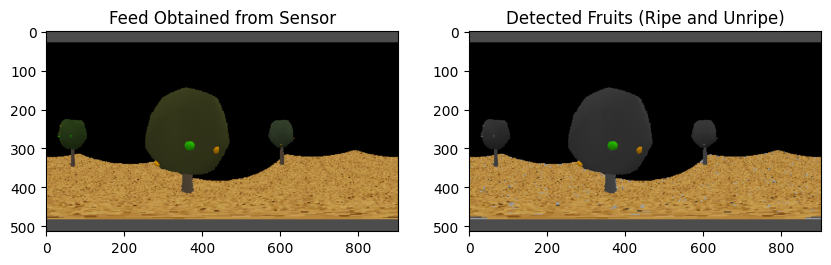

IM_1.png: Ripe fruits = 0, Unripe fruits = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


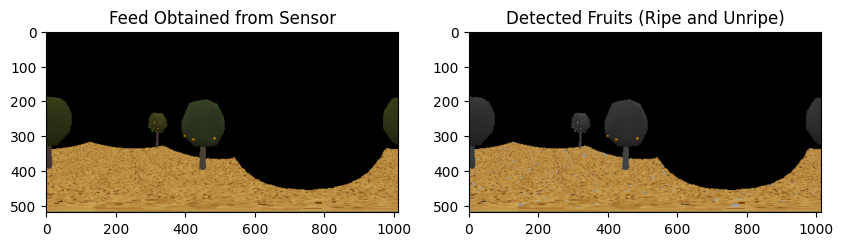

Screenshot 2024-11-12 054724.png: Ripe fruits = 0, Unripe fruits = 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


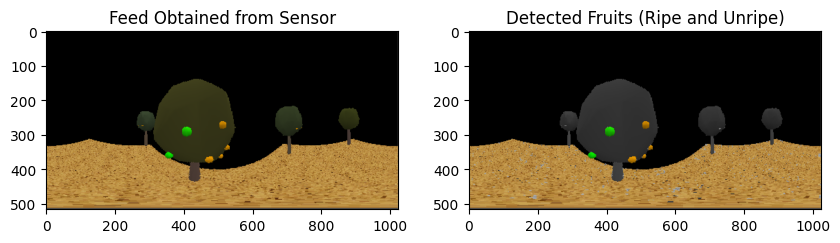

Screenshot 2024-11-12 054636.png: Ripe fruits = 4, Unripe fruits = 1


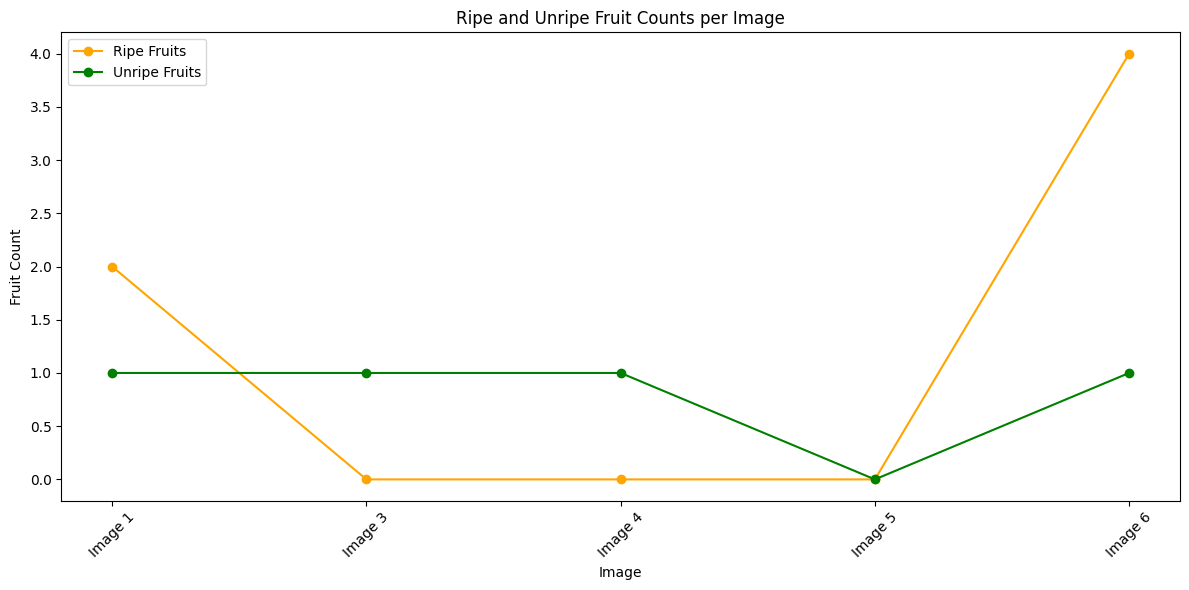

In [8]:
import matplotlib.pyplot as plt

def process_folder_with_counts_graph(folder_path):
    """Processes images in a given folder, counts fruits, and plots ripe and unripe fruit counts per image."""

    # Lists to store counts for each image
    ripe_counts = []
    unripe_counts = []
    image_names = []

    for idx, filename in enumerate(os.listdir(folder_path)):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            ripe_count, unripe_count = process_image(image_path)

            # Skip if the image could not be processed
            if ripe_count is not None and unripe_count is not None:
                ripe_counts.append(ripe_count)
                unripe_counts.append(unripe_count)
                image_names.append(f"Image {idx + 1}")

                # Display ripe and unripe counts for each image
                print(f"{filename}: Ripe fruits = {ripe_count}, Unripe fruits = {unripe_count}")

    # Plot the counts graph
    plt.figure(figsize=(12, 6))
    plt.plot(image_names, ripe_counts, label='Ripe Fruits', color='orange', marker='o')
    plt.plot(image_names, unripe_counts, label='Unripe Fruits', color='green', marker='o')
    plt.xlabel('Image')
    plt.ylabel('Fruit Count')
    plt.title('Ripe and Unripe Fruit Counts per Image')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

folder_path = '/content/new_cop'
process_folder_with_counts_graph(folder_path)


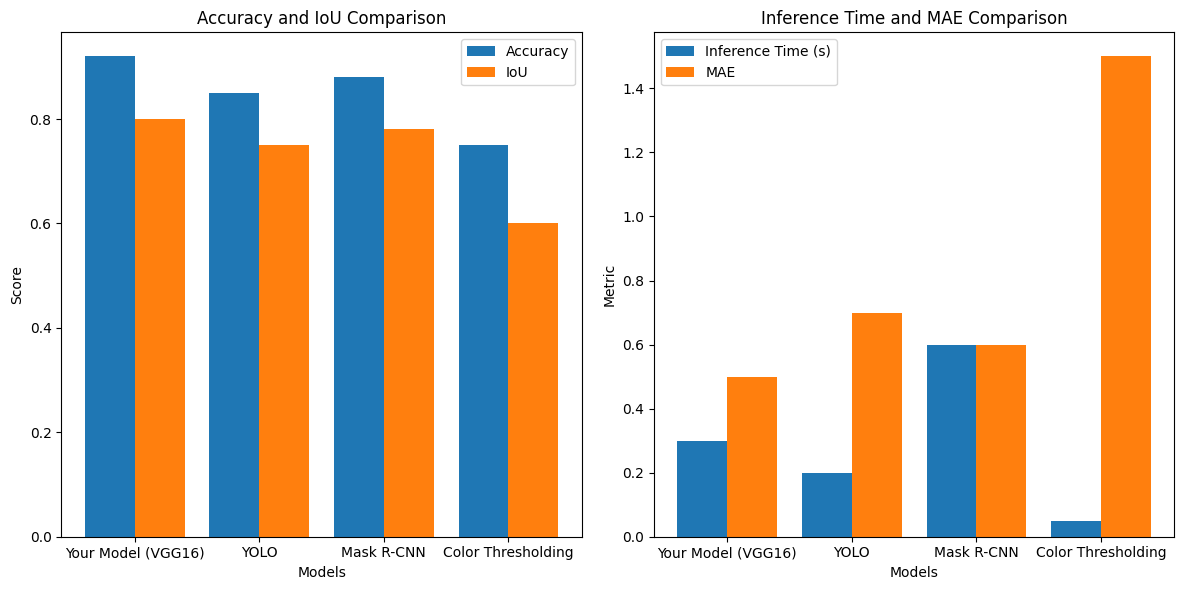

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with actual metrics from your experiments)
models = ['Your Model (VGG16)', 'YOLO', 'Mask R-CNN', 'Color Thresholding']
accuracy = [0.92, 0.85, 0.88, 0.75]
mae = [0.5, 0.7, 0.6, 1.5]
iou = [0.80, 0.75, 0.78, 0.60]
inference_time = [0.3, 0.2, 0.6, 0.05]  # in seconds

# Plotting accuracy and IoU
plt.figure(figsize=(12, 6))
x = np.arange(len(models))

# Accuracy and IoU Bar Plot
plt.subplot(1, 2, 1)
plt.bar(x - 0.2, accuracy, 0.4, label='Accuracy')
plt.bar(x + 0.2, iou, 0.4, label='IoU')
plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Accuracy and IoU Comparison")
plt.legend()

# Inference Time and MAE Bar Plot
plt.subplot(1, 2, 2)
plt.bar(x - 0.2, inference_time, 0.4, label='Inference Time (s)')
plt.bar(x + 0.2, mae, 0.4, label='MAE')
plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Metric")
plt.title("Inference Time and MAE Comparison")
plt.legend()

plt.tight_layout()
plt.show()
